# Shift-Only Time Warping

`affinewarp` supports two types of time warping: `PiecewiseWarping` and `ShiftWarping`. Here, we demonstrate `ShiftWarping` which is the simplest. See the other example notebook on the [ofc-1 dataset](https://crcns.org/data-sets/ofc/ofc-1) for a demonstration of `PiecewiseWarping`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Helper function for generating shifted data
from affinewarp.datasets import jittered_data

## Generate and plot the data

The data are a simple simulation of a single neuron with jittered activation on each trial. For this simple example, the data on each trial is a noisy continuous valued time series (not spike trains). If you like, you can think of the data as calcium fluorescence traces.

For now, `affinewarp` always assumes that data passed to `model.fit(...)` is a dense numpy array with dimensions:
```
data.shape == (num_trials, num_timebins, num_neurons)
```

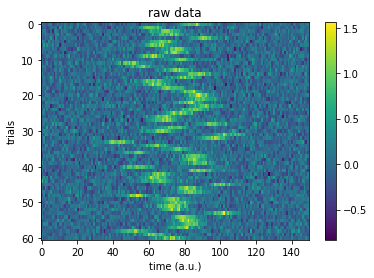

In [2]:
# Generate data using helper function.
data = jittered_data(t=np.linspace(-10,10,150), jitter=2, noise=.2)[-1]

# Plot data.
plt.imshow(np.squeeze(data), aspect='auto')
plt.title('raw data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

 ### Fit model, plot reconstruction error over time.
 
Since the data is very noisy, we'll add a roughness penalty to the model template to damp down high-frequency noise. This isn't entirely necessary for this simple example, but can be useful in real datasets.

Loss: 0.04: 100%|██████████| 20/20 [00:01<00:00, 17.21it/s]


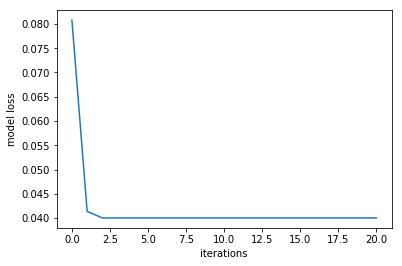

In [3]:
from affinewarp import ShiftWarping

# Create the model. Add a roughness penalty to the model template.
model = ShiftWarping(maxlag=.3, smoothness_reg_scale=10.)

# NOTE : you can also use PiecewiseWarping with `n_knots` parameter set to -1.
#
#  >> model = PiecewiseWarping(n_knots=-1, smoothness_reg_scale=10.)

# Fit the model.
model.fit(data, iterations=20)

# Plot model learning curve.
plt.plot(model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('model loss');

### Plot the model estimate of the data

Note that the model estimate is denoised compared to the raw data we plotted above.

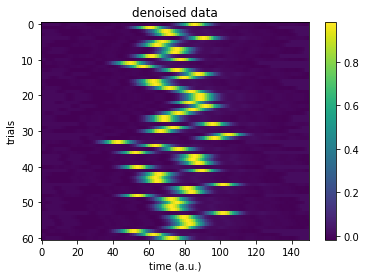

In [4]:
plt.imshow(model.predict().squeeze(), aspect='auto')
plt.title('denoised data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

### Apply the learned warping functions to align the data across trials

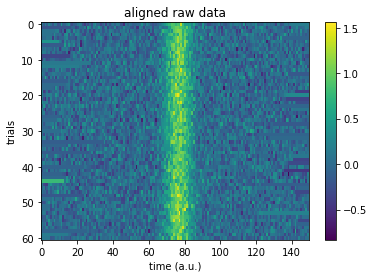

In [5]:
plt.imshow(model.transform(data).squeeze(), aspect='auto')
plt.title('aligned raw data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

### We can also plot the model template across all trials

This corresponds to the model's estimate in the warped/aligned temporal domain.

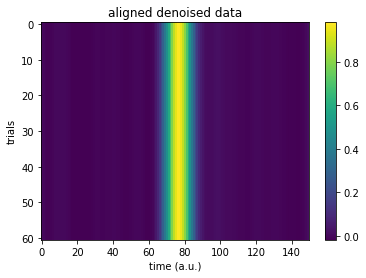

In [6]:
plt.imshow(np.tile(model.template, (1, data.shape[0])).T, aspect='auto')
plt.title('aligned denoised data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

### Simply trial-averaging over the raw data gives a smeared-out PSTH.

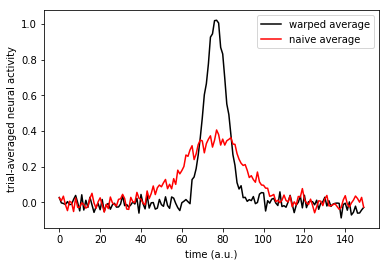

In [7]:
plt.plot(model.transform(data)[:,:,0].mean(axis=0), color='k', label='warped average')
plt.plot(data.mean(axis=0), color='r', label='naive average')
plt.ylabel('trial-averaged neural activity'), plt.xlabel('time (a.u.)'), plt.legend();

### Plot the model template vs the warped trial average

The model template is smoother because we added a roughness penalty (not present when we average over the aligned data).

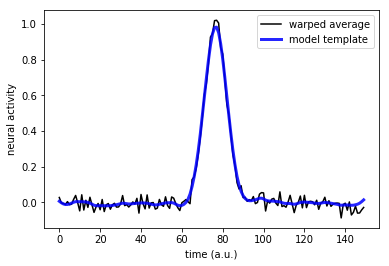

In [8]:
plt.plot(model.transform(data)[:,:,0].mean(axis=0), color='k', label='warped average')
plt.plot(model.template, '-', color='b', label='model template', lw=3, alpha=.85)
plt.ylabel('neural activity'), plt.xlabel('time (a.u.)'), plt.legend();